Yuhan Chen
3009389875

# Supervised, Semi-Supervised, and Unsupervised Learning

Download the Breast Cancer Wisconsin (Diagnostic) Data Set from:
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+
%28Diagnostic%29
. Download the data in
https://archive.ics.uci.edu/ml/
machine-learning-databases/breast-cancer-wisconsin/wdbc.data
, which
has IDs, classes (Benign=B, Malignant=M), and 30 attributes. This data has
two output classes

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os
import sys
import csv
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.utils import shuffle
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, auc, roc_curve, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix,auc,roc_curve
import warnings
warnings.filterwarnings('ignore')

In [88]:
column = ['ID', 'class']
df = pd.read_csv("../data/wdbc.data", header = None)
for i in range(1,31):
    column.append(str(i))
df = pd.read_csv("../data/wdbc.data", header = None, names = column)

In [158]:
def split_data(data):
    data_b = data.loc[data['class'] == 'B']
    data_m = data.loc[data['class'] == 'M']
    train_b = data_b.sample(frac = 0.80, random_state=200)
    train_m = data_m.sample(frac = 0.80, random_state=200)
    train = pd.concat([train_b, train_m])
    test = data.drop(train.index)   
    train.reset_index(drop=True,inplace=True)    
    test.reset_index(drop=True,inplace=True)
    train_x = train.iloc[:, 2:]
    train_y = train[["class"]]
    test_x = test.iloc[:, 2:]
    test_y = test[["class"]]
    return train_x, train_y, test_x, test_y

def scores(y, pred, norm_x, clf):
    acc = accuracy_score(y,pred)
    pre = precision_score(y,pred,pos_label='B')
    recall = recall_score(y,pred,pos_label='B')
    f1 = f1_score(y,pred,pos_label='B')
    auc = roc_auc_score(y, clf.decision_function(norm_x))
    return [acc, pre, recall, f1, auc]

def split_input_label_proportion(self, data, label_prop=0.2):
        input_list, label_list = [], []
        for items in data.values():
            items = np.array(items)
            if len(items) * label_prop >= 1:
                choose_as_label = np.zeros(len(items), dtype='bool')
                chosen_index = np.random.choice(len(items), size=int(label_prop * len(items)), replace=False).astype('int64')
                choose_as_label[chosen_index] = True
                input_list.append(items[np.logical_not(choose_as_label)])
                label_list.append(items[choose_as_label])
            else:
                input_list.append(items)
                label_list.append(np.array([]))

        return input_list, label_list 

def split_label(x, y):
    data = pd.concat([x, y],axis=1, join='inner')
    label_df_b = data.loc[data['class'] == 'B'].sample(frac=0.50)
    label_df_m = data.loc[data['class'] == 'M'].sample(frac=0.50)
    label_data =pd.concat([label_df_b, label_df_m])
    unlabel_data = data.drop(label_data.index)
    unlabel_data.drop(["class"],axis=1,inplace=True)
    while len(unlabel_data) > 0:
        label_df_x = label_data.drop(["class"],axis=1)
        label_df_y = label_data[["class"]]
        label_x_normalize = pd.DataFrame(preprocessing.normalize(label_df_x), columns=df.columns[2:])
        kfold = KFold(n_splits=5)
        c_range = np.logspace(-2, 7, 16)
        params = {'C':c_range}
        clf = GridSearchCV(LinearSVC(penalty='l1', dual=False), param_grid=params, cv=kfold)
        clf.fit(label_x_normalize,label_df_y)
        y= clf.decision_function(unlabel_data)
        y= abs(y)
        data_to_label = unlabel_data.iloc[y.argsort()[::-1][:1]]
        unlabel_data = unlabel_data.drop(data_to_label.index)
        pred = clf.predict(data_to_label)
        data_to_label["class"] = pred[0]
        label_data = pd.concat([label_data,data_to_label])
    return label_data, unlabel_data

def clfhelper1(df):
    error_list = []
    for i in range(50):
        train_x, train_y, test_x, test_y = splhelper2(df, 900)
        scaler = MinMaxScaler()
        norm_train_x, norm_test_x = scaler.fit_transform(train_x), scaler.transform(test_x)
        kfold = KFold(n_splits=5)
        c_range = np.logspace(-2, 7, 16)
        params = {'C':c_range}
        train_df = pd.concat([train_x, train_y],axis=1, join='inner')
        test_df = pd.concat([test_x, test_y],axis=1, join='inner')
        error = active_learning(norm_train_x, train_y, norm_test_x, test_y, params, kfold)
        error_list.append(error)
        print(i)
    return error_list

def clfhelper2(df):
    error_lis = []
    for i in range(50):
        train_x, train_y, test_x, test_y = splhelper2(df2, 900)
        scaler = MinMaxScaler()
        norm_train_x, norm_test_x = scaler.fit_transform(train_x), scaler.transform(test_x)
        kfold = KFold(n_splits=5)
        c_range = np.logspace(-2, 7, 16)
        params = {'C':c_range}
        train_df = pd.concat([train_x, train_y],axis=1, join='inner')
        test_df = pd.concat([test_x, test_y],axis=1, join='inner')
        error = passive_learning(norm_train_x, train_y, norm_test_x, test_y, params, kfold)
        error_list_passive.append(error)
        print(i)
    return error_list_passive


In [90]:
df_x = df.iloc[:, 2:]
df_y = df.iloc[:, :2]
df_b = df.loc[df['class'] == 'B']
df_m = df.loc[df['class'] == 'M']
train_x, train_y, test_x, test_y = split_data(df)

In [91]:
df_x

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,attribute10,...,attribute21,attribute22,attribute23,attribute24,attribute25,attribute26,attribute27,attribute28,attribute29,attribute30
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [92]:
train_x

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,attribute10,...,attribute21,attribute22,attribute23,attribute24,attribute25,attribute26,attribute27,attribute28,attribute29,attribute30
0,14.920,14.93,96.45,686.9,0.08098,0.08549,0.05539,0.03221,0.1687,0.05669,...,17.18,18.22,112.00,906.6,0.10650,0.2791,0.3151,0.11470,0.2688,0.08273
1,14.860,16.94,94.89,673.7,0.08924,0.07074,0.03346,0.02877,0.1573,0.05703,...,16.31,20.54,102.30,777.5,0.12180,0.1550,0.1220,0.07971,0.2525,0.06827
2,13.210,25.25,84.10,537.9,0.08791,0.05205,0.02772,0.02068,0.1619,0.05584,...,14.35,34.23,91.29,632.9,0.12890,0.1063,0.1390,0.06005,0.2444,0.06788
3,12.890,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,...,13.62,15.54,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915
4,9.676,13.14,64.12,272.5,0.12550,0.22040,0.11880,0.07038,0.2057,0.09575,...,10.60,18.04,69.47,328.1,0.20060,0.3663,0.2913,0.10750,0.2848,0.13640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,21.610,22.28,144.40,1407.0,0.11670,0.20870,0.28100,0.15620,0.2162,0.06606,...,26.23,28.74,172.00,2081.0,0.15020,0.5717,0.7053,0.24220,0.3828,0.10070
452,20.440,21.78,133.80,1293.0,0.09150,0.11310,0.09799,0.07785,0.1618,0.05557,...,24.31,26.37,161.20,1780.0,0.13270,0.2376,0.2702,0.17650,0.2609,0.06735
453,11.420,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.20980,0.8663,0.6869,0.25750,0.6638,0.17300
454,23.210,26.97,153.50,1670.0,0.09509,0.16820,0.19500,0.12370,0.1909,0.06309,...,31.01,34.51,206.00,2944.0,0.14810,0.4126,0.5820,0.25930,0.3103,0.08677


#### i.Train an L1-penalized SVM to classify the data. Use 5 fold cross validation to choose the penalty parameter. Use normalized data. Report the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

In [93]:
svmtrain = []
svmtest = []

for m in range(1,31):
    df_b = df.loc[df['class'] == 'B']
    df_m = df.loc[df['class'] == 'M']
    train_b = df_b.sample(frac = 0.80, random_state=200)
    train_m = df_m.sample(frac = 0.80, random_state=200)
    train = pd.concat([train_b, train_m])
    test = df.drop(train.index)   
    train.reset_index(drop=True,inplace=True)    
    test.reset_index(drop=True,inplace=True)
    train_x = train.iloc[:, 2:]
    train_y = train[["class"]]
    test_x = test.iloc[:, 2:]
    test_y = test[["class"]]
    norm_train_x = pd.DataFrame(preprocessing.normalize(train_x), columns=df.columns[2:])
    norm_test_x = pd.DataFrame(preprocessing.normalize(test_x), columns=df.columns[2:])
    kfold = KFold(n_splits=5)
    c_range = np.logspace(-2, 7, 16)
    params = {'C':c_range}
    clf = GridSearchCV(LinearSVC(penalty='l1', dual=False), param_grid=params, cv=kfold)
    clf.fit(norm_train_x,train_y)
    train_pred = clf.predict(norm_train_x)
    test_pred = clf.predict(norm_test_x)
    svmtrain.append(scores(train_y, train_pred, norm_train_x, clf))
    svmtest.append(scores(test_y, test_pred, norm_test_x, clf))

In [143]:
mean_scoresvm = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'f1-score', 'AUC'])
mean_scoresvm.loc['Training Set',:] = np.array(svmtrain).mean(axis=0).tolist()
mean_scoresvm.loc['Test Set',:] = np.array(svmtest).mean(axis=0).tolist() 
mean_scoresvm

,Accuracy,Precision,Recall,f1-score,AUC
Training Set,0.98019,0.979236,0.989394,0.984289,0.998268
Test Set,0.982301,0.985915,0.985915,0.985915,0.996412


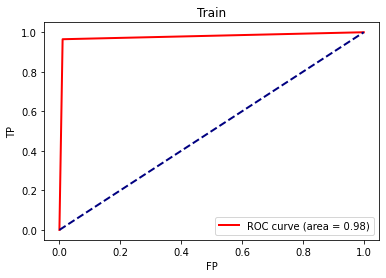

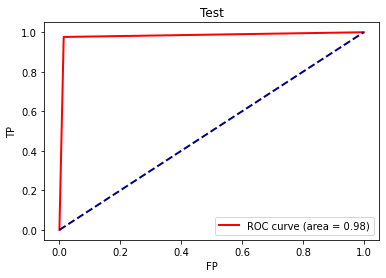

In [97]:

def draw(y,pred,naming):
    y_b = label_binarize(y, classes=['B','M'], neg_label=0, pos_label=1, sparse_output=False)
    pred_b = label_binarize(pred, classes=['B','M'], neg_label=0, pos_label=1, sparse_output=False)
    fpr, tpr, thresholds = roc_curve(y_b, pred_b)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('FP')
    plt.ylabel('TP')
    plt.title(naming)
    plt.legend(loc="lower right")
    plt.show()
    
def draw2(real,pred,naming):
    fpr, tpr, thresholds = roc_curve(real,pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(naming)
    plt.legend(loc="lower right")
    plt.show()

draw(train_y,train_pred,'Train')
confusion_matrix(train_y,train_pred)
draw(test_y,test_pred,'Test')
confusion_matrix(test_y,test_pred)


#### ii.select 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabelled data. You can select them randomly.

In [98]:
def split_label(x, y):
    data = pd.concat([x, y],axis=1, join='inner')
    label_df_b = data.loc[data['class'] == 'B'].sample(frac=0.50)
    label_df_m = data.loc[data['class'] == 'M'].sample(frac=0.50)
    label_data =pd.concat([label_df_b, label_df_m])
    
    unlabel_data = data.drop(label_data.index)
    unlabel_data.drop(["class"],axis=1,inplace=True)

    while len(unlabel_data) > 0:
        label_df_x = label_data.drop(["class"],axis=1)
        label_df_y = label_data[["class"]]
        label_x_normalize = pd.DataFrame(preprocessing.normalize(label_df_x), columns=df.columns[2:])

        kfold = KFold(n_splits=5)
        c_range = np.logspace(-2, 7, 16)
        params = {'C':c_range}
    
        clf = GridSearchCV(LinearSVC(penalty='l1', dual=False), param_grid=params, cv=kfold)
        clf.fit(label_x_normalize,label_df_y)

        y= clf.decision_function(unlabel_data)
        y= abs(y)

        data_to_label = unlabel_data.iloc[y.argsort()[::-1][:1]]
        unlabel_data = unlabel_data.drop(data_to_label.index)

        pred = clf.predict(data_to_label)
        data_to_label["class"] = pred[0]

        label_data = pd.concat([label_data,data_to_label])
    
    return label_data, unlabel_data

In [104]:
semi_train = []
semi_test = []

for m in range(1,31):
    print(m)
    train_x, train_y, test_x, test_y = split_data(df)
    print(m)
    label_train_df, unlabel_train_df = split_label(train_x, train_y)
    print(m)
    label_train_x = label_train_df.drop(["class"],axis=1)
    label_train_y = label_train_df[["class"]]
    label_data_total = pd.concat([label_train_x,label_train_y])
    norm_label_train_x = pd.DataFrame(preprocessing.normalize(label_train_x), columns=df.columns[2:])
    norm_test_x = pd.DataFrame(preprocessing.normalize(test_x), columns=df.columns[2:])
    kfold = KFold(n_splits=5)
   #https://blog.csdn.net/weixin_41988628/article/details/83098130 
    c_range = np.logspace(-2, 7, 16)
    params = {'C':c_range}
    clf = GridSearchCV(LinearSVC(penalty='l1', dual=False), param_grid=params, cv=kfold)
    clf.fit(norm_label_train_x,label_train_y)
    train_pred = clf.predict(norm_label_train_x)
    test_pred = clf.predict(norm_test_x)
    semi_train.append(scores(label_train_y, train_pred, norm_label_train_x, clf))
    semi_test.append(scores(test_y, test_pred, norm_test_x, clf))


1
1
1
2
2
2
3
3
3
4
4
4
5
5
5
6
6
6
7
7
7
8
8
8
9
9
9
10
10
10
11
11
11
12
12
12
13
13
13
14
14
14
15
15
15
16
16
16
17
17
17
18
18
18
19
19
19
20
20
20
21
21
21
22
22
22
23
23
23
24
24
24
25
25
25
26
26
26
27
27
27
28
28
28
29
29
29
30
30
30


In [144]:
semi_score = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'f1-score', 'AUC'])
semi_score.loc['Training Set',:] = np.array(semi_train).mean(axis=0).tolist()
semi_score.loc['Test Set',:] = np.array(semi_test).mean(axis=0).tolist() 
semi_score

,Accuracy,Precision,Recall,f1-score,AUC
Training Set,0.937354,0.955685,0.955825,0.955678,0.983273
Test Set,0.936283,0.910264,0.998122,0.951918,0.990085


In [106]:
confusion_matrix(label_train_y,train_pred)

array([[309,  19],
       [ 25, 103]])

In [107]:
confusion_matrix(test_y,test_pred)

array([[71,  0],
       [ 9, 33]])

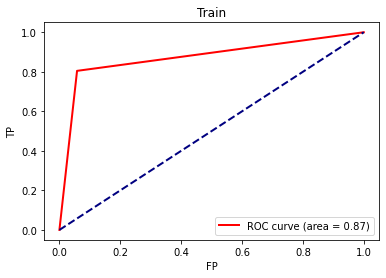

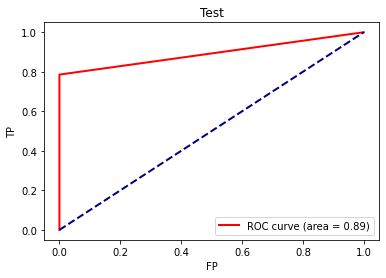

In [108]:
draw(label_train_y,train_pred,'Train')
draw(test_y,test_pred,'Test')

#### iii.Run k-means algorithm on the whole training set. Ignore the labels of the data, and assume k = 2.

In [113]:
###https://medium.com/@rishit.dagli/build-k-means-from-scratch-in-python-e46bf68aa875
### https://stanford.edu/~cpiech/cs221/handouts/kmeans.html
def dist(labels, centers, data_x):
    dist = np.ndarray((data_x.shape[0],))
    for i, x in enumerate(data_x):
        center = centers[labels[i]]
        dist[i] = np.linalg.norm(x - center)
    return dist

def kmeans(dataSet, k):
    # Initialize centroids randomly
    numFeatures = dataSet.getNumFeatures()
    centroids = getRandomCentroids(numFeatures, k)
    
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = None
    
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids = centroids
        iterations += 1
        
        # Assign labels to each datapoint based on centroids
        labels = getLabels(dataSet, centroids)
        
        # Assign centroids based on datapoint labels
        centroids = getCentroids(dataSet, labels, k)
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    return centroids

def find_major_cluster(labels, dist, data):
    pred_label = labels
    for cluster in [0, 1]:
        indx, = np.where(labels == cluster)
        major_indx = sorted(indx.tolist(), key=lambda i : dist[i])[:30]
        major_label = data.iloc[major_indx].squeeze().value_counts().index[0]
        if major_label == 'B':
            pred_label[indx] = 1
        elif major_label == 'M':
            pred_label[indx] = 0
#     largest_cluster_idx = np.argmax(counter.values())
#     largest_cluster_center = kmeans.cluster_centers_[largest_cluster_idx ]
    return pred_label

In [115]:
from sklearn.metrics import pairwise_distances_argmin
from sklearn.cluster import KMeans
from sklearn.metrics import auc, roc_curve

un_train = []
un_test = []
for m in range(30):
    train_x, train_y, test_x, test_y = split_data(df)
    scaler = MinMaxScaler()
    norm_train_x, norm_test_x = scaler.fit_transform(train_x), scaler.transform(test_x)
    
    clf = KMeans(n_clusters=2, random_state=m)
    train_clusters = clf.fit_predict(norm_train_x)
    train_dist = dist(clf.labels_, clf.cluster_centers_, norm_train_x)
    train_pred_class = find_major_cluster(clf.labels_, train_dist, train_y)
    train_y['class'].replace('M', 0, inplace=True)
    train_y['class'].replace('B', 1, inplace=True)
    train_class = train_y['class'].values.tolist()
    
    clf = KMeans(n_clusters=2, random_state=i)
    train_clusters = clf.fit_predict(norm_test_x)
    test_dist = dist(clf.labels_, clf.cluster_centers_, norm_test_x)
    test_pred_class = find_major_cluster(clf.labels_, test_dist, test_y)
    test_y['class'].replace('M', 0, inplace=True)
    test_y['class'].replace('B', 1, inplace=True)
    test_class = test_y['class'].values.tolist()
    
    
    acc_train = accuracy_score(train_class, train_pred_class)
    pre_train = precision_score(train_class, train_pred_class)
    recall_train = recall_score(train_class, train_pred_class)
    f1_train = f1_score(train_class, train_pred_class)
    auc_train = auc(train_class, train_pred_class)
    un_train.append([acc_train, pre_train, recall_train, f1_train, auc_train])
   
    acc_test = accuracy_score(test_class, test_pred_class)
    pre_test = precision_score(test_class, test_pred_class)
    recall_test = recall_score(test_class, test_pred_class)
    f1_test = f1_score(test_class, test_pred_class)
    fpr, tpr, thresholds = roc_curve(test_class, test_pred_class, pos_label = 1)
    auc_test = auc(fpr, tpr)
    un_test.append([acc_test, pre_test, recall_test, f1_test, auc_test])

In [145]:
un_score = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'f1-score', 'AUC'])
un_score.loc['Training Set',:] = np.array(un_train).mean(axis=0).tolist()
un_score.loc['Test Set',:] = np.array(un_test.mean(axis=0).tolist() 
un_score

,Accuracy,Precision,Recall,f1-score,AUC
Training Set,0.723684,0.722573,0.986014,0.825644,0.833333
Test Set,0.938053,0.921053,0.985915,0.952381,0.921529


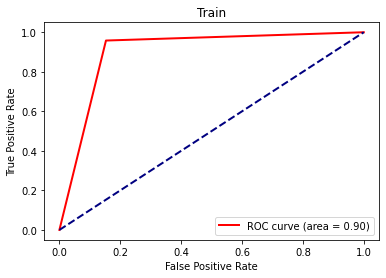

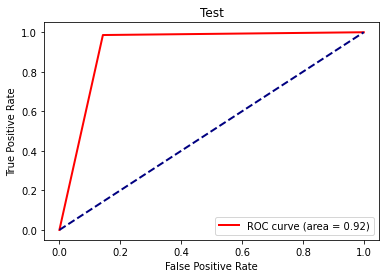

In [117]:
draw2(train_class, train_pred_class,'Train')
draw2(test_class, test_pred_class,'Test')

#### iv.Spectral Clustering: Repeat 1(b)iii using spectral clustering, which is clus- tering based on kernels.3 Research what spectral clustering is. Use RBF kernel with gamma=1 or find a gamma for which the two clutsres have the same balance as the one in original data set (if the positive class has p and the negative class has n samples, the two clusters must have p and n members). Do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters . Instead, use fit − predict method.

In [121]:
from sklearn.metrics import pairwise_distances_argmin
from sklearn.preprocessing import MinMaxScaler

basetrain = []
basetest = []
for m in range(30):
    data_b = df.loc[df['class'] == 'B']
    data_m = df.loc[df['class'] == 'M']
    train_b = data_b.sample(frac = 0.80, random_state=200)
    train_m = data_m.sample(frac = 0.80, random_state=200)
    train = pd.concat([train_b, train_m])
    used_train_select = train.reset_index(drop = True)
    test = df.drop(train.index)
    test_select = test.reset_index(drop = True)
    train.reset_index(drop=True,inplace=True) 
    test.reset_index(drop=True,inplace=True)
    train_x = train.iloc[:, 2:]
    train_y = train[["class"]]
    test_x = test.iloc[:, 2:]
    test_y = test[["class"]]
    train_df = pd.concat([train_x, train_y],axis=1, join='inner')
    test_df = pd.concat([test_x, test_y],axis=1, join='inner')
    scaler = MinMaxScaler()
    norm_train_x, norm_test_x = scaler.fit_transform(train_x), scaler.transform(test_x)
    clf = SpectralClustering(n_clusters=2,affinity='rbf',n_init=5,random_state=m).fit(norm_train_x)
    train_centers = []
    
    for i in [0,1]:
        train_centers.append(np.mean(norm_train_x[clf == i], axis = 0).tolist())
    train_dist = dist(clf.labels_, train_centers, norm_train_x)
    train_pred_class = find_major_cluster(clf.labels_, train_dist, train_y)
    train_y['class'].replace('M', 0, inplace=True)
    train_y['class'].replace('B', 1, inplace=True)
    train_class = train_y['class'].values.tolist()
    acc_train = accuracy_score(train_class, train_pred_class)
    pre_train = precision_score(train_class, train_pred_class)
    recall_train = recall_score(train_class, train_pred_class)
    f1_train = f1_score(train_class, train_pred_class)
    auc_train = auc(train_class, train_pred_class)
    basetrain.append([acc_train, pre_train, recall_train, f1_train, auc_train])
    clf = SpectralClustering(n_clusters=2,affinity='rbf',n_init=5,random_state=m).fit(norm_test_x)
    test_centers = []
    
    for i in [0,1]:
        test_centers.append(np.mean(norm_test_x[clf == i], axis = 0).tolist())
    test_dist = dist(clf.labels_, test_centers, norm_test_x)
    test_pred_class = find_major_cluster(clf.labels_, test_dist, test_y)
    test_y['class'].replace('M', 0, inplace=True)
    test_y['class'].replace('B', 1, inplace=True)
    test_class = test_y['class'].values.tolist()
    acc_test = accuracy_score(test_class, test_pred_class)
    pre_test = precision_score(test_class, test_pred_class)
    recall_test = recall_score(test_class, test_pred_class)
    f1_test = f1_score(test_class, test_pred_class)
    fpr, tpr, thresholds = roc_curve(test_class, test_pred_class, pos_label = 1)
    auc_test= auc(fpr, tpr)   
    basetest.append([acc_test, pre_test, recall_test, f1_test, auc_test])

In [146]:
basescore = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'f1-score', 'AUC'])
basescore.loc['Training Set',:] = np.array(basetrain).mean(axis=0).tolist()
basescore.loc['Test Set',:] = np.array(basetest).mean(axis=0).tolist() 
basescore

,Accuracy,Precision,Recall,f1-score,AUC
Training Set,0.697953,0.689323,0.997203,0.810739,1
Test Set,0.582596,0.35364,0.433333,0.389451,0.634127


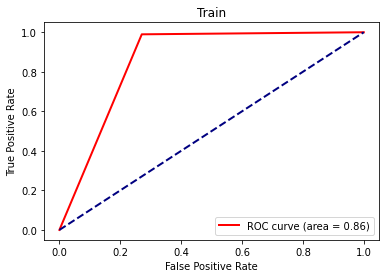

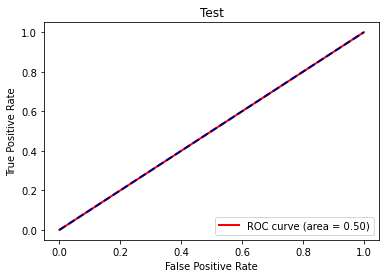

In [147]:
draw2(train_class, train_pred_class,'Train')
draw2(test_class, test_pred_class,'Test')

In [149]:

print(' supervised accuracy score')

print(mean_scoresvm['Accuracy'])

print('  semi accuracy score')
print(mean_score2['Accuracy'])
print('  unsupervised accuracy score')
print(semi_score['Accuracy'])
print('  base')
print(basescore ['Accuracy'])


 supervised accuracy score
Training Set     0.98019
Test Set        0.982301
Name: Accuracy, dtype: object
  semi accuracy score
Training Set    0.937354
Test Set        0.936283
Name: Accuracy, dtype: object
  unsupervised accuracy score
Training Set    0.723684
Test Set        0.938053
Name: Accuracy, dtype: object
  base
Training Set    0.697953
Test Set        0.582596
Name: Accuracy, dtype: object


v.supervised learning provides the best performance, semi supervised learning performs better than unsupervised method 

### 2. Active Learning Using Support Vector Machines

In [138]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
df2 = pd.read_csv(url,  header = None)
df2.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
df2.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [137]:
def splhelper2(data, num):
    data_0 = data.loc[data['class'] == 0]
    data_1 = data.loc[data['class'] == 1]
    train_0 = data_0.sample(n=int(num/2))
    train_1 = data_1.sample(n=int(num/2))
    train_0_select = train_0.reset_index(drop = True)
    train_1_select = train_1.reset_index(drop = True)
    train = pd.concat([train_0, train_1])
    test = data.drop(train.index)
    train.reset_index(drop=True,inplace=True)
    train_select = train.reset_index(drop = True)
    test.reset_index(drop=True,inplace=True)
    test_select = test.reset_index(drop = True)
    train_x = train.iloc[:, :-1]
    train_y = train[["class"]]
    test_x = test.iloc[:, :-1]
    test_y = test[["class"]]
    return train_x, train_y, test_x, test_y

In [132]:
def splhelper2(data, num):
    data_0 = data.loc[data['class'] == 0]
    data_1 = data.loc[data['class'] == 1]
    train_0 = data_0.sample(n=int(num/2))
    train_1 = data_1.sample(n=int(num/2))
    train_0_select = train_0.reset_index(drop = True)
    train_1_select = train_1.reset_index(drop = True)
    train = pd.concat([train_0, train_1])
    test = data.drop(train.index)
    train.reset_index(drop=True,inplace=True)
    train_select = train.reset_index(drop = True)
    test.reset_index(drop=True,inplace=True)
    test_select = test.reset_index(drop = True)
    train_x = train.iloc[:, :-1]
    train_y = train[["class"]]
    test_x = test.iloc[:, :-1]
    test_y = test[["class"]]
    return train_x, train_y, test_x, test_y

In [152]:
##reference：https://towardsdatascience.com/applying-svm-based-active-learning-on-multi-class-datasets-ba6aacdb52d1
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, auc, roc_curve, classification_report
def active_learning(train_x, train_y, test_x, test_y, params, kfold):
    unused = np.arange(train_x.shape[0])
    np.random.shuffle(unused)
    pool = unused[:10]
    unused = unused[10:]
    used = []
    used.extend(pool)
    error = []
    while len(used) <= 900:
        used_x = train_x[used]
        used_y = train_y.iloc[used]
        clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False),  param_grid=params, cv=kfold)
        clf.fit(used_x, used_y)        
        pred_y = clf.predict(test_x)
        result = classification_report(test_y, pred_y, output_dict=True)
        error.append(1 - result['accuracy'])
        if len(unused) == 0:
            break        
        dist = clf.decision_function(train_x[unused])        
        close_10 = np.arange(len(unused))
        sorted(close_10, key=lambda i : abs(dist[i]))
        unused = unused[close_10]
        unused = unused[10:]
        pool = unused[:10]
        used.extend(pool)
    return error
##reference：https://towardsdatascience.com/applying-svm-based-active-learning-on-multi-class-datasets-ba6aacdb52d1
def passive_learning(train_x, train_y, test_x, test_y, params, kfold):    
    unused = np.arange(train_x.shape[0])
    used = []
    error = []    
    while len(unused) > 0: 
        np.random.shuffle(unused)
        pool = unused[:10]
        unused = unused[10:]
        used.extend(pool)        
        used_x = train_x[used]
        used_y = train_y.iloc[used]
        clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False),  param_grid=params, cv=kfold)
        clf.fit(used_x, used_y)
        pred_y = clf.predict(test_x)
        result = classification_report(test_y, pred_y, output_dict=True)
        error.append(1 - result['accuracy'])
    return error

In [ ]:
error_list_active = clfhelper1(df2)

In [159]:
error_list_passive= clfhelper2(df2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


### (b).Repeat each of the following two procedures 50 times. You will have 50 errors for 90 SVMs per each procedure.

#### i.TrainaSVMwithapoolof10randomlyselecteddatapointsfromthetraining set using linear kernel and L1 penalty. Select the penalty parameter using 5-fold cross validation.4 Repeat this process by adding 10 other randomlyselected data points to the pool, until you use all the 900 points. Do NOT replace the samples back into the training set at each step. Calculate the test error for each SVM. You will have 90 SVMs that were trained using 10, 20, 30, ... , 900 data points and their 90 test errors. You have implemented passive learning.


In [160]:
np.mean(error_list_passive)

0.02252612994350282

In [161]:
np.mean(error_list_active)

0.021133239171374756

#### ii.TrainaSVMwithapoolof10randomlyselecteddatapointsfromthetraining set5 using linear kernel and L1 penalty. Select the parameters of the SVM with 5-fold cross validation. Choose the 10 closest data points in the training set to the hyperplane of the SVM6 and add them to the pool. Do not replace the samples back into the training set. Train a new SVM using the pool. Repeat this process until all training data is used. You will have 90 SVMs that were trained using 10, 20, 30,..., 900 data points and their 90 test errors. You have implemented active learning.

### (c).Average the 50 test errors for each of the incrementally trained 90 SVMs in 2(b)i and 2(b)ii. By doing so, you are performing a Monte Carlo simulation. Plot average test error versus number of training instances for both active and passive learners on the same figure and report your conclusions. Here, you are actually obtaining a learning curve by Monte-Carlo simulation.

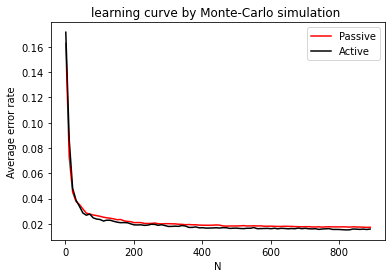

In [162]:
x = np.arange(1, 900,10)
fig, axes = plt.subplots()
meactive = np.mean(np.array(error_list_active), axis=0)
mepassive = np.mean(np.array(error_list_passive), axis=0)
axes.plot(x, mepassive, color = "red", label='Passive')
axes.plot(x, meactive, color = 'black', label='Active')
axes.set_xlabel("N")
axes.set_ylabel("Average error rate")
axes.legend()
axes.set_title("learning curve by Monte-Carlo simulation ")
plt.show()